In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn import linear_model
import warnings  
warnings.filterwarnings('ignore')



In [178]:
# Step 0: Load the proper csvs

xtrain = pd.read_csv("X_train.csv")
xtrain = xtrain.iloc[:, 1:]
xtest = pd.read_csv("X_test.csv")
xtest = xtest.iloc[:, 1:]
ytrain = pd.read_csv("Y_train.csv")

In [179]:
# Step 1: Treat missing values
# Treat missing values as column medians. Important (apparently) to use the medians from the training set in the test set

xtrain = xtrain.fillna(xtrain.median())
xtest = xtest.fillna(xtrain.median())

In [180]:
# Step 2: Scale the training and test data

scaler = preprocessing.StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain_scaled, columns = xtrain.columns)
xtest_scaled = scaler.fit_transform(xtest)
xtest = pd.DataFrame(xtest_scaled, columns = xtest.columns)

In [181]:
# Step 3: Remove unnecessary id column from ytrain 

ytrain1 = ytrain.loc[:, "y"]
ytrain2 = pd.DataFrame(data = ytrain1.values, columns= ['y'])
ytrain = ytrain2

In [182]:
# reshuffling data

xtrain['y'] = ytrain
xtrain = xtrain.sample(frac=1).reset_index(drop=True)
ytrain = xtrain['y']
xtrain = xtrain.drop('y', axis = 1)

In [183]:
# Outlier detection with local outlier factor
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=700, contamination=0.1)
outliers = clf.fit_predict(xtrain)

# Remove outliers from xtrain and ytrain


outliers = outliers == 1
print(np.count_nonzero(outliers))
xtrain_ensemble = xtrain[outliers]
ytrain = ytrain[outliers]

1090


In [184]:
'''

#Feature selection  -- cross validated inside the loop below
# option 1  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
k_best = 500
xtrain = SelectKBest(mutual_info_regression, k=k_best).fit_transform(xtrain, ytrain)


# option 2
sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(xtrain, ytrain)
selected_feat = xtrain.columns[(sel.get_support())]
xtrain = xtrain.loc[:,selected_feat]
xtest = xtest.loc[:,selected_feat]
'''


'\n\n#Feature selection  -- cross validated inside the loop below\n# option 1  \nfrom sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import mutual_info_regression\nk_best = 500\nxtrain = SelectKBest(mutual_info_regression, k=k_best).fit_transform(xtrain, ytrain)\n\n\n# option 2\nsel = SelectFromModel(RandomForestClassifier(n_estimators = 200))\nsel.fit(xtrain, ytrain)\nselected_feat = xtrain.columns[(sel.get_support())]\nxtrain = xtrain.loc[:,selected_feat]\nxtest = xtest.loc[:,selected_feat]\n'

In [90]:
# Cross validating ensemble

folds = 5

cv_mean_scores = []
cv_stds = []
estimators = np.array([200, 350, 400])
mutual_features = np.array([70, 150, 250, 350])
alphas = np.array([0.01, 0.03, 0.1, 0.3])
max_depth = np.array([20, 40, 60])

for n in estimators:
    for best in mutual_features:
        for a in alphas: 
            for depth in max_depth: 
                
                xtrain = SelectKBest(mutual_info_regression, k = best).fit_transform(xtrain_ensemble, ytrain_ensemble)
                r1 = RandomForestRegressor(n_estimators = n, random_state = 42, max_depth = depth, bootstrap = True)
                r2 = linear_model.Lasso(alpha= a)
                r3 = xgb.XGBRegressor(objective  = "reg:squarederror", random_state = 52, n_estimators=200)
                er = VotingRegressor([('rf', r1), ('lasso', r2), ('xgb', r3)])
                scores = cross_val_score(estimator = er, X = xtrain,
                                   y = ytrain_ensemble, scoring = 'r2', cv = folds)
                cv_mean_scores.append(np.mean(scores))   
                cv_stds.append(np.std(scores))
                print("Mean Validation score {}".format(np.mean(scores)))
                print("Std Validation score {}".format(np.std(scores)))
                
        


Mean Validation score 0.5356786531562483
Std Validation score 0.08528096198344745
Mean Validation score 0.5332099906225032
Std Validation score 0.08357174327351075
Mean Validation score 0.5336738546691011
Std Validation score 0.07826274176003374
Mean Validation score 0.5321438557847966
Std Validation score 0.0851585291162828
Mean Validation score 0.5342665677948756
Std Validation score 0.08185473810553937
Mean Validation score 0.5369356969756409
Std Validation score 0.0892526340588144
Mean Validation score 0.5380390935356321
Std Validation score 0.08788292397292127
Mean Validation score 0.5297738909899686
Std Validation score 0.07598787562151886
Mean Validation score 0.5302298095070652
Std Validation score 0.0862223834868987
Mean Validation score 0.5263735507693845
Std Validation score 0.0782306866907978
Mean Validation score 0.5298764247270504
Std Validation score 0.09277977945929676
Mean Validation score 0.5236942613778266
Std Validation score 0.07720090790747172
Mean Validation scor

Mean Validation score 0.5401440424367884
Std Validation score 0.08864026461446017
Mean Validation score 0.5396606895519549
Std Validation score 0.08285468510983736
Mean Validation score 0.5382224490562233
Std Validation score 0.08950896850741819
Mean Validation score 0.5348670614480546
Std Validation score 0.09187136168017106
Mean Validation score 0.5360912849766819
Std Validation score 0.0873160380181032
Mean Validation score 0.5308411148494503
Std Validation score 0.08457124766424033
Mean Validation score 0.5287746668417393
Std Validation score 0.08328220963814537
Mean Validation score 0.5275669079163416
Std Validation score 0.09533445193873691
Mean Validation score 0.5201645229109414
Std Validation score 0.09388621442762517
Mean Validation score 0.5308643745376637
Std Validation score 0.09182966205708952
Mean Validation score 0.528437877434307
Std Validation score 0.08896649620121196
Mean Validation score 0.5283363350313375
Std Validation score 0.0866161937591147
Mean Validation sco

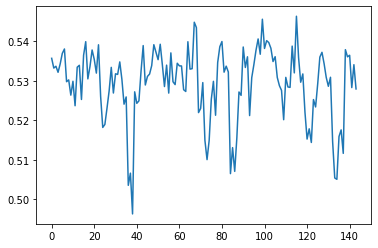

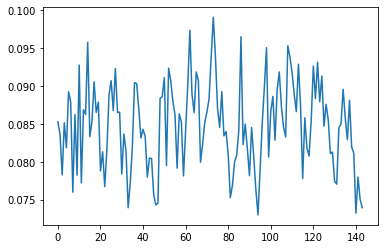

In [91]:
fig = plt.figure()
ax = plt.axes()
ax.plot(cv_mean_scores)

fig = plt.figure()
ax = plt.axes()
ax.plot(cv_stds)

In [185]:
# 68th combination yields max CV values
# chosen values: 200, 150, 0.03, 20

#xtrain = SelectKBest(mutual_info_regression, k = 150).fit_transform(xtrain_ensemble, ytrain_ensemble)
from sklearn.feature_selection import SelectKBest, f_classif

# Create and fit selector
selector = SelectKBest(f_classif, k=150)
selector.fit(xtrain_ensemble, ytrain_ensemble)
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
xtrain = xtrain_ensemble.iloc[:,cols]
xtest = xtest.iloc[:,cols]

r1 = RandomForestRegressor(n_estimators = 200, random_state = 42, max_depth = 20, bootstrap = True)
r2 = linear_model.Lasso(alpha= 0.03)
r3 = xgb.XGBRegressor(objective  = "reg:squarederror", random_state = 52, n_estimators=200)
er = VotingRegressor([('rf', r1), ('lasso', r2), ('xgb', r3)])
scores = cross_val_score(estimator = er, X = xtrain,
          y = ytrain_ensemble, scoring = 'r2', cv = 5)
cv_mean_scores.append(np.mean(scores))   
cv_stds.append(np.std(scores))
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))
    
er.fit(xtrain, ytrain)
predict = er.predict(X = xtest)
index = pd.read_csv("sample.csv")
index['y'] = predict



Mean Validation score -0.05796338592638297
Std Validation score 0.03159205651211491


In [186]:
index.to_csv("ensemble.csv")

In [ ]:
#trying a different ensemble 
#careful:featuresmust be the same in the training and test set

folds = 5

cv_mean_scores = []
cv_stds = []
estimators = np.array([50, 100, 200])
RF_sel = np.array([200, 300, 400])
max_depth = np.array([20, 40, 60])

for n in estimators:
    for m in RF_sel:
            for depth in max_depth: 
                
                sel = SelectFromModel(RandomForestClassifier(n_estimators = m))
                sel.fit(xtrain_ensemble, ytrain_ensemble)
                selected_feat = xtrain_ensemble.columns[(sel.get_support())]
                xtrain = xtrain_ensemble.loc[:,selected_feat]
                r1 = RandomForestRegressor(n_estimators = n, random_state = 42, max_depth = depth, bootstrap = True)
                r3 = xgb.XGBRegressor(objective  = "reg:squarederror", random_state = 52, n_estimators=200)
                er = VotingRegressor([('rf', r1), ('lasso', r2), ('xgb', r3)])
                scores = cross_val_score(estimator = er, X = xtrain,
                                   y = ytrain_ensemble, scoring = 'r2', cv = folds)
                cv_mean_scores.append(np.mean(scores))   
                cv_stds.append(np.std(scores))
                print("Mean Validation score {}".format(np.mean(scores)))
                print("Std Validation score {}".format(np.std(scores)))
                
                


Mean Validation score 0.5083349208166623
Std Validation score 0.04565757927245662
